# 用pytorch实现全连接神经网络

## 载入数据

In [18]:
import os
import struct
import torch as t
import numpy as np

In [19]:
# 载入数据
def load_mnist(path, kind):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

os.path.join()用于读取时拼接路径
```python
magic, n = struct.unpack('>II', lbpath.read(8))
labels = np.fromfile(lbpath, dtype=np.uint8)
```
通过使用上面两行代码, 我们首先读入 magic number, 它是一个文件协议的描述, 也是在我们调用 fromfile 方法将字节读入 NumPy array 之前在文件缓冲中的 item 数(n). 作为参数值传入 struct.unpack 的 >II 有两个部分:
- \>: 这是指大端(用来定义字节是如何存储的); 如果你还不知道什么是大端和小端, Endianness 是一个非常好的解释. (关于大小端, 更多内容可见<<深入理解计算机系统 – 2.1 节信息存储>>)
- I: 这是指一个无符号整数.
(以上内容来自[liuchengxu_的CSDN博客](https://blog.csdn.net/simple_the_best/article/details/75267863 "liuchengxu_的CSDN博客"))

In [20]:
x_train,y_train=load_mnist('./mnist','train')
print('训练集:',x_train.shape[0],x_train.shape[1])
x_test,y_test=load_mnist('./mnist','t10k')
print('测试集:',x_test.shape[0],x_test.shape[1])

训练集: 60000 784
测试集: 10000 784


数据集的格式表示共有60000张照片，60000行，每行784列，表示28*28*1=784个像素

## 可视化处理

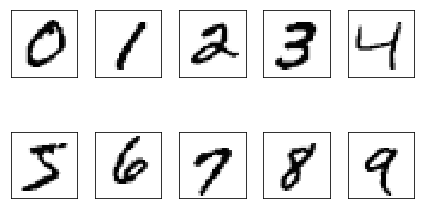

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True, )

ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')   # Greys为白底黑字，gray为黑底白字
#interpolation 插值，作nearest插值运算

ax[0].set_xticks([]) #表示不设置刻度
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

上面这一部分调用matplotlib进行可视化处理
plt.subplots() 返回一个 Figure实例fig 和一个 AxesSubplot实例ax ，fig代表整个图像，<font color=red>ax代表坐标轴和画的图</font>
plt.subplots(2,5)之后返回的ax为2*5的数组，所以用ax.flatten()进行折叠处理，得到一维数组，然后将x_train中的像素写入ax


## 网络
从反向逆推导入手，来看一看pytorch如何实现全连接层的构建
首先知道我们的输入是60000个784维的数据，则每个神经元就有784个权值，再加上1个偏置项  y=Wx+b

In [ ]:
from torch import nn
from torch.autograd import Variable as v